In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision import models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#Data 
0->Covid
1->No Covid

In [4]:
classes=['Covid','No Covid']
batch_size=4

In [5]:
# reshape all images to 64x64 and apply tensor transformation
dataset = torchvision.datasets.ImageFolder(root="./Full",transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Resize([227,227])
                                                            # transforms.Grayscale(num_output_channels=1)
                                                            ]))
# testset = torchvision.datasets.ImageFolder(root="./xray",train=False,transform=transforms.Compose([transforms.Resize([300,305]),transforms.ToTensor()]))
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

In [6]:
print(len(dataset))
trainset,testset,valset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.1*len(dataset)),round(0.1*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)
valloader=torch.utils.data.DataLoader(valset,batch_size=batch_size,shuffle=False)

8088


In [7]:
print(len(dataset))
trainset,testset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False)
print(len(trainset)/batch_size,len(testset)/batch_size)

8088
1617.5 404.5


In [8]:
dataiter=iter(trainloader)
images,labels=dataiter.next()
print(images.shape,labels)

torch.Size([4, 3, 227, 227]) tensor([0, 0, 1, 1])


In [9]:
def plot_img(img):
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# Preparing The CNN

In [10]:
def evaluation(dataloader,model):
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
    print(correct,total)
    model.train()
    return 100*correct/total

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.representation_network=nn.Sequential(
            nn.Conv2d(3,32,3), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2,stride=3),
            nn.Dropout(p=0.2),
            nn.Conv2d(32,32,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=3),
            nn.Dropout(p=0.2)
        )
        self.classification_network=nn.Sequential(
            nn.Linear(18432,128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128,1)
        )
    def forward(self,x):
#         print(x.shape)
        x=self.representation_network(x)
#         print(x.shape)
        # flattening of the vector=> same dimension of first index(batch size) , everythign else is flattened(-1)
        x=x.view(x.size(0),-1)
#        print(x.shape)
        x=self.classification_network(x)
#        print(x.shape)
        return x

In [ ]:
def train(net,dataloader,epochs=15):
    loss_fn=nn.BCEWithLogitsLoss().to(device)
    opt=optim.Adam(params=net.parameters())
    for epoch in range(epochs):
        for i,data in enumerate(dataloader,0):
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            opt.zero_grad()
            outputs=net(inputs)
            labels=labels.unsqueeze(-1)
            labels = labels.type_as(outputs)
    #         print(outputs)
            loss=loss_fn(outputs,labels)
            loss.backward()
            opt.step()
            torch.cuda.empty_cache()
            del inputs,labels,outputs

In [17]:
net = CNN()
# net=torch.load("./coronaCNN.pt")
# net.load_state_dict(torch.load("./coronaCNN_State.pt"))
opt=optim.Adam(params=net.parameters())
net=net.to(device)

In [18]:
print(net(images.to(device)).shape)

torch.Size([4, 1])


iteration 0/1618.0, Loss=0.6591470837593079 
iteration 100/1618.0, Loss=68.26841750741005 
iteration 200/1618.0, Loss=128.39015713334084 
iteration 300/1618.0, Loss=177.00568325817585 
iteration 400/1618.0, Loss=220.0170859247446 
iteration 500/1618.0, Loss=262.8177606090903 
iteration 600/1618.0, Loss=302.1695932075381 
iteration 700/1618.0, Loss=342.9611216150224 
iteration 800/1618.0, Loss=385.62130435556173 
iteration 900/1618.0, Loss=424.91487753205 
iteration 1000/1618.0, Loss=461.89482205733657 
iteration 1100/1618.0, Loss=495.4144021682441 
iteration 1200/1618.0, Loss=534.6011643633246 
iteration 1300/1618.0, Loss=566.1629699245095 
iteration 1400/1618.0, Loss=600.67247691378 
iteration 1500/1618.0, Loss=632.1327940905467 
iteration 1600/1618.0, Loss=665.3698928570375 
Epoch: 0/5, Loss=669.6395044093952


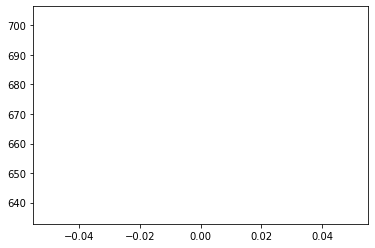

iteration 0/1618.0, Loss=0.37604430317878723 
iteration 100/1618.0, Loss=30.213077559135854 
iteration 200/1618.0, Loss=56.67579428409226 
iteration 300/1618.0, Loss=88.3678798743058 
iteration 400/1618.0, Loss=121.16217092354782 
iteration 500/1618.0, Loss=151.1508635461796 
iteration 600/1618.0, Loss=186.4038468634244 
iteration 700/1618.0, Loss=214.4776369794272 
iteration 800/1618.0, Loss=244.4281298746355 
iteration 900/1618.0, Loss=279.630730508361 
iteration 1000/1618.0, Loss=313.817258086754 
iteration 1100/1618.0, Loss=341.854491857579 
iteration 1200/1618.0, Loss=373.4196114160586 
iteration 1300/1618.0, Loss=404.30022326787 
iteration 1400/1618.0, Loss=435.09832398523577 
iteration 1500/1618.0, Loss=463.7493984720204 
iteration 1600/1618.0, Loss=489.7650627773255 
Epoch: 1/5, Loss=498.14403851889074


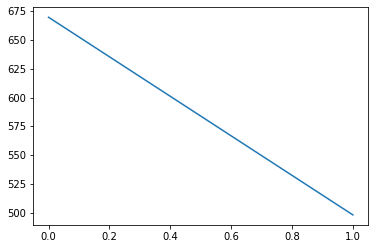

iteration 0/1618.0, Loss=0.06420566886663437 
iteration 100/1618.0, Loss=28.142546148970723 
iteration 200/1618.0, Loss=52.841015906538814 
iteration 300/1618.0, Loss=76.56291417311877 
iteration 400/1618.0, Loss=101.64902490261011 
iteration 500/1618.0, Loss=125.03149364888668 
iteration 600/1618.0, Loss=150.62877760990523 
iteration 700/1618.0, Loss=174.65948376781307 
iteration 800/1618.0, Loss=198.96415709514986 
iteration 900/1618.0, Loss=229.72165085404413 
iteration 1000/1618.0, Loss=250.40314470481826 
iteration 1100/1618.0, Loss=273.4426530900528 
iteration 1200/1618.0, Loss=292.9528208494303 
iteration 1300/1618.0, Loss=320.1808431330719 
iteration 1400/1618.0, Loss=348.02214873727644 
iteration 1500/1618.0, Loss=367.3416040898883 
iteration 1600/1618.0, Loss=387.23800716514233 
Epoch: 2/5, Loss=393.66090507491026


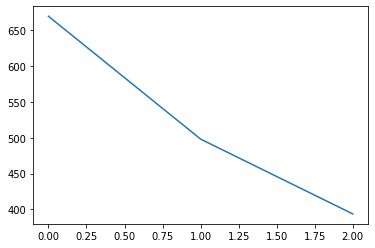

iteration 0/1618.0, Loss=0.029890654608607292 
iteration 100/1618.0, Loss=19.773211588384584 
iteration 200/1618.0, Loss=44.01338167989161 
iteration 300/1618.0, Loss=68.02268083335366 
iteration 400/1618.0, Loss=87.55061754293274 
iteration 500/1618.0, Loss=112.3669343983056 
iteration 600/1618.0, Loss=130.84488840552513 
iteration 700/1618.0, Loss=151.35110748035368 
iteration 800/1618.0, Loss=168.1848626389401 
iteration 900/1618.0, Loss=192.07122875138884 
iteration 1000/1618.0, Loss=217.04358120070538 
iteration 1100/1618.0, Loss=233.64328188404033 
iteration 1200/1618.0, Loss=257.97982642763236 
iteration 1300/1618.0, Loss=276.24684765859274 
iteration 1400/1618.0, Loss=294.75624795019394 
iteration 1500/1618.0, Loss=314.0812991593266 
iteration 1600/1618.0, Loss=335.02004780945344 
Epoch: 3/5, Loss=339.18928548553004


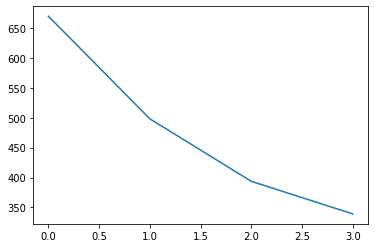

iteration 0/1618.0, Loss=0.029747923836112022 
iteration 100/1618.0, Loss=17.381461842684075 
iteration 200/1618.0, Loss=35.06173384777503 
iteration 300/1618.0, Loss=54.16984503582353 
iteration 400/1618.0, Loss=69.08339845307637 
iteration 500/1618.0, Loss=84.20260579296155 
iteration 600/1618.0, Loss=100.78425722039538 
iteration 700/1618.0, Loss=119.03251823448227 
iteration 800/1618.0, Loss=135.48066013204516 
iteration 900/1618.0, Loss=152.39034079533303 
iteration 1000/1618.0, Loss=168.5104228053533 
iteration 1100/1618.0, Loss=185.64700610240106 
iteration 1200/1618.0, Loss=205.59423708505346 
iteration 1300/1618.0, Loss=224.94623371001217 
iteration 1400/1618.0, Loss=247.19849118671846 
iteration 1500/1618.0, Loss=265.97396737959934 
iteration 1600/1618.0, Loss=282.98856242062175 
Epoch: 4/5, Loss=285.30028149232385


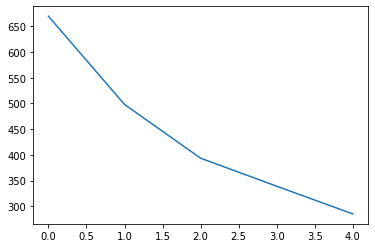

<IPython.core.display.Javascript object>

In [19]:
%%notify -m "Cell has completed exec"
loss_arr=[]
loss_epoch=[]
epochs=5
loss_fn = nn.BCEWithLogitsLoss().to(device)
best_model_loss,best_model=1000000,net.state_dict()
n_iters=np.ceil(len(trainset)/batch_size)
for epoch in range(epochs):
    loss_this_epoch=0
    loss_arr=[]
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        opt.zero_grad()
        outputs=net(inputs)
        labels=labels.unsqueeze(-1)
        labels = labels.type_as(outputs)
#         print(outputs)
        loss=loss_fn(outputs,labels)
        loss_this_epoch+=loss.item()
        loss_arr.append(loss.item())
        loss.backward()
        opt.step()
        torch.cuda.empty_cache()
        del inputs,labels,outputs
        if i%100 == 0:
            print(f'iteration {i}/{n_iters}, Loss={sum(loss_arr)} ')
#             plt.plot(loss_arr)
#             plt.show()
    if loss_this_epoch < best_model_loss:
            best_model_loss=loss_this_epoch
            best_model=copy.deepcopy(net.state_dict())
    loss_epoch.append(loss_this_epoch)
    print(f'Epoch: {epoch}/{epochs}, Loss={loss_this_epoch}')
    plt.plot(loss_epoch)
    plt.show()

In [20]:
%%notify -m "completed"
print(evaluation(testloader,net))

1465 1618
90.54388133498146


<IPython.core.display.Javascript object>

In [22]:
torch.save(net.state_dict(),"./py3/coronaCNN_State.pt")
torch.save(net,"./py3/coronaCNN.pt")

Test Accuracy and K-Fold Cross Validation

## Cross Validation

In [23]:
from sklearn.model_selection import KFold

In [24]:
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [25]:
def k_fold_cv(model,dataset,loss_function,k_folds=5,epochs=10):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)): 
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
              dataset, 
              batch_size=batch_size, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
              dataset,
              batch_size=batch_size, sampler=test_subsampler)

        # Init the neural network
        network = model
        network.apply(reset_weights)
        optimizer = optim.Adam(network.parameters())
        # Run the training loop for defined number of epochs
        for epoch in range(0, epochs):

            # Print epoch
            print(f'Starting epoch {epoch+1}')

            # Set current loss value
            current_loss = 0.0

            # Iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):

                # Get inputs
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device)
                # Zero the gradients
                optimizer.zero_grad()

                # Perform forward pass
                outputs = network(inputs)
                targets = targets.unsqueeze(-1)
                targets = targets.type_as(outputs)
                # Compute loss
                loss = loss_function(outputs, targets)

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()

                # Print statistics
                current_loss += loss.item()
                if i % 500 == 499:
                    print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, current_loss / 500))
                    current_loss = 0.0

        # Process is complete.
        print('Training process has finished. Saving the trained model.')
        save_path = f'./py3/CNN-fold-{fold}.pth'
        torch.save(network, save_path)

        # Evaluation for this fold
        correct, total = 0, 0
        with torch.no_grad():

            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                inputs,targets=inputs.to(device),targets.to(device)
                # Generate outputs
                outputs = network(inputs)
                m = nn.Sigmoid()
                outputs=m(outputs)
                pred=outputs>=0.5
                pred=pred.flatten()
                # Set total and correct
                total += targets.size(0)
                correct += (pred == targets).sum().item()

            # Print accuracy
            print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
            print('--------------------------------')
            results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

In [ ]:
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    net.load_state_dict(torch.load("./py3/coronaCNN_State.pt"))

In [26]:
%%notify -m "Completed"
net=CNN().to(device)
loss_fn=nn.BCEWithLogitsLoss().to(device)
data_set=trainset
k_fold_cv(net,data_set,loss_fn,epochs=10)

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=18432, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=1, bias=True)
Starting epoch 1
Loss after mini-batch   500: 0.542
Loss after mini-batch  1000: 0.431
Starting epoch 2
Loss after mini-batch   500: 0.321
Loss after mini-batch  1000: 0.293
Starting epoch 3
Loss after mini-batch   500: 0.264
Loss after mini-batch  1000: 0.228
Starting epoch 4
Loss after mini-batch   500: 0.219
Loss after mini-batch  1000: 0.195
Starting epoch 5
Loss after mini-batch   500: 0.170
Loss after mini-batch  1000: 0.195
Starting epoch 6
Loss after mini-batch   500: 0.166
Loss after mini-batch  1000: 0.157
Starting epoch 7
Loss after mini-batch   500: 0.139
Loss after mini-batch  1000: 

<IPython.core.display.Javascript object>

In [ ]:
reset_weights(net)
train(net,trainloader)

In [27]:
evaluation(testloader,net)

1486 1618


91.84177997527811

In [28]:
torch.save(net,"./CNN5.pt")

In [10]:
def report(dataloader,model):
    y_true,y_pred=torch.tensor([]),torch.tensor([])
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            y_true=torch.cat((y_true,copy.deepcopy(labels.cpu())),0)
            y_pred=torch.cat((y_pred,copy.deepcopy(pred.cpu())),0)
#             print(y_pred,y_true,y_pred==y_true,pred==labels)
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
#             print((pred==labels).sum())
    print("Accuracy: ",accuracy_score(y_true,y_pred))
    print("Precision: ",precision_score(y_true,y_pred))
    print("Recall: ",recall_score(y_true,y_pred))
    print("F1-Score: ",f1_score(y_true,y_pred))
    print("AUC: ",roc_auc_score(y_true,y_pred))
    print(correct,total)
#     print(y_true,y_pred)
    y_pred=y_pred.flatten()
    y_true=y_true.flatten()
#     print(classification_report(y_true, y_pred))
    
    model.train()
    return 100*correct/total

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [12]:
report(testloader,net)

Accuracy:  0.9202719406674907
Precision:  0.9196102314250914
Recall:  0.9229828850855746
F1-Score:  0.9212934716290421
AUC:  0.9202414425427873
1489 1618


92.02719406674908